# Quantum speedups in finance

### Notebook objectives:

In this challenge we will gain the following skills:
1. Understand the basics of how financial instruments are typically priced using Monte Carlo methods
2. Implement a quantum algorithm to price a financial instrument (in this case, we consider derivative contracts called options)
3. Understand the pros/cons of using the quantum approach

## Introduction

The world of finance is a complicated one to model and predict. The financial markets, in particular, are influenced by so many external factors and contain multiple different investors with different objectives. This means that traditional modelling techniques, like multiple linear regression, often struggle when trying to explain investors' behaviours or perform certain tasks in finance, such as predicting the price of a stock. Due to these complexities, we need more sophisticated models and numerous techniques have been proposed to produce such robust models for financial instruments like stocks. 

In Africa, the dynamics of the financial markets are arguably even more complicated. In this notebook, we discuss what types of financial instruments we can encounter in the South African market, particularly those that are liquid (meaning they are frequently traded and accurately valued). Illiqid instruments are also prevalent in Africa and are more difficult to evaluate and price, since they are not often traded. 

Here, we introduce a common pricing technique for a particular instrument called an option. This technique rests on Monte Carlo sampling which we show can achieve a quadratic speed up in pricing the option by replacing the classical Monte Carlo sampling approach with a quantum algorithm that leverages quantum effects to compute things faster. 

## 1. What is a financial instrument?

A financial instrument is any asset that can be traded between various parties. For example, shares of a company are equity instruments, and debt, cash and even contracts can be considered as financial instruments. 

In general, we can divide financial instruments into several categories, such as cash instruments, asset or debt-based instruments and derivative instruments. In this challenge, we will focus on the last category, namely, derivatives. These instruments get their name from the fact that their price is *derived* based on the price of a separate underlying quantity. In particular, we will consider derivatives called European options. 

<img src="instruments.png" width=1000 height=1000 />

### Option contracts

Options are financial derivatives that are defined explicitly by contracts. These contracts give the buyer of the option the right, but not the obligation, to buy or sell a specific underlying asset at an agreed-upon price sometime in the future. 

- Options that give the buyer the right to *buy* the underlying asset are called **call options** 

- Options that give the buyer the right to *sell* the underlying asset are called **put options**. 

In both cases, the price to buy or sell the asset at, is agreed upon in the contract and called the **strike price**.

For example, let's assume that the share price of a company called ABC is currently trading at $S_0 =$ 50 ZAR. You believe that in 1 months time, the share price will double to 100 ZAR. You can either buy the share now for 50 ZAR, or you could buy a 1-month call option for a much cheaper price of 5 ZAR. If the price of the ABC share does indeed double in 1 months time, then you can exercise your option right to buy the ABC share at the agreed up strike price (which will be lower than the actual share price). This may sound a little tricky, so let's make it concrete by going through an example with various scenarios we can encounter.

Recall that the current price of ABC is $S_0 =$ 50 ZAR. A 1-month call option with a strike price of $K =$ 80 ZAR is available to purchase for $P_{\mathrm{call}} =$ 5 ZAR. Let's consider the scenarios of buying an ABC share today or the call option.

#### Today:

Scenario 1: Buying a share of ABC today
Investment = $S_0 =$ 50 ZAR

Scenario 2: Buying a 1-month call option on ABC
Investment = $P_{\mathrm{call}} =$ 5 ZAR

#### In 1-months time:
Since option contracts are valid for a pre-determined period of time, their value at the expiration date is called the *payoff* that you will recieve. Technically, the price of an ABC share could be trading at any value greater than or equal to 0 ZAR. Let's imagine that the price after 1-month $S_t$ can be 40 ZAR, 60 ZAR or 100 ZAR and look at the payoffs for each scenario. 

- $S_t =$ 40 ZAR \
    Scenario 1: Since you own the share of ABC and purchased it at 50 ZAR, you will lose 10 ZAR. I.e. the payoff will be a loss of -10 ZAR. \
    Scenario 2: The strike price is higher than the actual share price. Thus, you would not execute the option to buy ABC at $K =$ 80 ZAR when you can purchase the share on the market at 40 ZAR. You will lose out on the price you paid for the call option and so the payoff will be a loss of -5 ZAR.


- $S_t =$ 60 ZAR \
Scenario 1: The payoff will be the profit you made from buying the share at 50 ZAR and it's current price. I.e., payoff = 60 - 50 = 10 ZAR. \
Scenario 2: The strike price is still higher than the share price. Thus, you would not execute the option and lose 5 ZAR.


- $S_t =$ 100 ZAR \
Scenario 1: payoff = 100 - 50 = 50 ZAR \
Scenario 2: Here, the strike price is lower than the market price so it makes sense to execute the option. By doing so, you can buy the share at the strike price of 80 ZAR and the profit is therefore = 100 - 80 = 20 ZAR. However, remember that you also paid a premium for the option so the total payoff is 100 - 80 - 5 = 15 ZAR.

At this stage, you might be wondering why buy the option at all? And it kind of seems like betting? What's important to keep in mind is the initial investment you have to put up in order to buy the actual ABC share vs buying the call option. Buying the share requires a much higher investment and you run the risk of losing a lot more money if the share price drops below the price you initially paid for it. Whereas with the option, if the share price drops below the strike price, you can just let the option expire and lose a maximum of 5 ZAR (the price you paid for the option). There are also other reasons to purchase options, such as hedging against risk or offsetting other trades. In general, you can read more about these strategies here: https://www.investopedia.com/trading/options-strategies/

# Pricing options

Now, how on earth do we begin to price these option contracts? Previously, we said the price of a 1-month call option linked to the ABC share price was 5 ZAR. But is that price fair? And how would be go about determining the fair price of these options in general? 

If we think about what should affect the fair price of an option, it boils down to understanding the what the price of the underlying asset it is linked to will be in the future. Due to the random (also called stochastic) nature of most of the parameters that go into pricing the underlying assets that options are defined on, calculating the fair price can be a difficult task, and whilst analytical models exist for the basic types of options, the simplifying assumptions required for these models often limit their applicability. Thus, numerical methods that estimate the fair price have to be employed for option pricing, with Monte Carlo being one of the most popular. 

## 2. How does Monte Carlo work?

Monte Carlo methods are a class of computational algorithms that are based on random sampling and repeated computation. At a high level, imagine you have a function (or equation) that is described by multiple variables and you're interested in solving that function, but it is analytically difficult to do so because the function depends on lots of complicated variables. 

A Monte Carlo approach simply samples random values for the parameters of your function from an underlying distribution and computes the function multiple times, each time using a different set of randomly sampled values. In doing so, we can obtain an expected value for the function we are trying to evaluate by taking an average over all the computed values of the function. This allows us to estimate function values without having to analytically solve them directly.

<img src="MCpic.png" width=650 height=650 />

You can read more about how Monte Carlo works in this blog post that discusses how to use the technique to estimate the value of pi: https://medium.com/swlh/estimate-pi-with-monte-carlo-a74995862501

### Monte Carlo in finance

Monte Carlo simulation is often used in finance to value and analyse instruments, portfolios and investments by simulating the sources of uncertainty that affect their value [cite: https://www.cmi.ac.in/~shariq/Shariq%20files/option_pricing.pdf]. 

In the case of options, Monte Carlo methods are used to develop a price distribution for the underlying asset. If we have a price distribution of the underlying asset, then we can begin to get a sense of what the fair price for the option should be. 

To illustrate this, we have to first make assumptions about the factors that could influence the price of the underlying asset and hence, influence the value of the option.

### Monte Carlo methods for option pricing

The goal of option pricing is to estimate the option's payoff at the expiration date. In other words, how much profit can you expect to make from the option? If the underlying asset's price is expected to go up a lot, then you can expect to make more money if you can buy the underlying asset at a cheap price when it is worth a lot. In that case, the option price should be high since the option to buy the underlying asset at a cheaper price is quite valuable. 

<br>
The steps to price an option are as follows:

1. Model the price of the underlying asset which the option is based on, and any other sources of uncertainty, as random variables $\textbf{X}=\{X_1, X_2, . . . , X_N\} $ which follow a stochastic process.
$$ \thinspace $$
2. Generate a large number, $M$, of random values which can serve as price paths $\{\textbf{X}_1, \textbf{X}_2, . . . ,  \textbf{X}_N\} $ for the underlying asset. These random values should be drawn from the probability distribution implied by the stochastic process. Let's call this distribution $\mathbb{P}$.
$$ \thinspace $$
3. Once we have lots of simulated price paths for the underlying asset, we can calculate the option’s payoff for each of the generated price paths, which we can label as $f(\textbf{X}_i)$. Then we can compute an estimator for the expectation value of the payoff as an average across all paths, i.e. $\mathbb{E}_\mathbb{P}[f(\textbf{X})]$ can be approximated by
$$ \mathbb{\hat{E}}_\mathbb{P}[f(\textbf{X})]= \frac{1}{M}\sum_{i=1}^M f(\textbf{X}_i) $$
$$ \thinspace $$
4. Lastly, discount the calculated expectation value to get the option's fair value today.

In step 4, the discounting process requires knowledge of interest rates at future dates which is itself an important question from a financial modelling perspective. However, for the types of options we consider, this process is not computationally challenging and can be performed classically after the payoff calculation. We therefore do not discount the expected payoff for simplicity and can ignore step 4.

Let's look at a simple example to illustrate how classical Monte Carlo works using Python.

In [1]:
# Let's import some libraries and functions we will need

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Let's look at a 1-month call option linked to the underlying share price of a new company called QuantumTech. We can formulate the expected payoff in 1 months time, and hence the price of the call option, as follows:

$$P_{\mathrm{call}} = \max(S_T - K, 0)$$

where $S_T$ is the price of the QuantumTech share in $T =$ 1 month and $K$ is the pre-agreed upon strike price. 

Since we know $K$ and $T$, we need to estimate $S_T$. I.e. we need to use Monte Carlo methods to estimate QuantumTech's share price in 1 month. But what function can sample from in order to get the Monte Carlo estimate?

In financial literature, there are several results that help us answer this question. Share prices are often assumed to follow a random process called a Generalised Wiener Process. We can use this random process to create lots of estimates for the price of a QuantumTech share. Let's assume we expect QuantumTech to have roughly a positive return for the month of $r = 0.05$ and there will be some volatility around this return which we denote as $\sigma = 0.4$. Then, the change in share price, $dS_T$, can be written as

$$ dS_T = rS_TdT + \sigma S_T dW_T $$

where $dW_T$ is a Wiener process (see https://www.whoi.edu/fileserver.do?id=21268&pt=10&p=17232 for more technical details of this process). Using a convenient result called Itô's lemma, we can then derive the formula for the share price at time T as 

$$S_T = S_0e^{(r-\frac{1}{2}\sigma^2)T + \sigma \sqrt{T}W_T}$$

where $S_0$ is the price of a QuantumTech share today. Thus, often shares are modelled using log-normal distributions.

Now we can code up this function and use lots of random values to evaluate it, in order to calculate a price distribution for QuantumTech in 1 months time.

In [2]:
# Monte Carlo valuation of a European call option 

# set a random seed to reproduce our results
np.random.seed(42)

# set the parameters
S0 = 50 # initial price of the underlying asset
K = 55 # strike price
r = 0.05 # average return of the underlying
sigma = 0.4 # volatility of the underlying
T = 1 # time till execution
t = 30 # number of time steps we want to divide T in
dt = T / t # incremental time step size
M = 1000 # number of paths to simulate

# Simulating M price paths with t time steps
# sum instead of cumsum would also do if only the final values at end of the month (i.e. at time T) are of interest
S = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * dt + sigma * math.sqrt(dt)* np.random.standard_normal((t + 1, M)), axis=0))

# Calculating the Monte Carlo estimator for the expected payoff
P_call = sum(np.maximum(S[-1] - K, 0)) / M

# Results output
print("The call option value is:  {:0.2f} ZAR.\n".format(P_call))

The call option value is:  7.64 ZAR.



Let's visualise the multiple paths that the underlying share price of QuantumTech could take. The resulting call option value is calculated using an average of these paths.

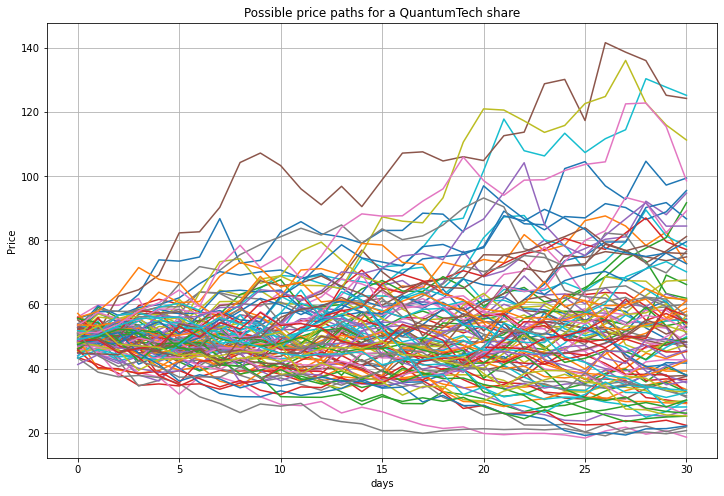

In [3]:
num_paths_to_plot = 100
plt.figure(figsize= (12,8))
plt.plot(S[:, :num_paths_to_plot])
plt.grid(True)
plt.xlabel('days')
plt.ylabel('Price')
plt.title('Possible price paths for a QuantumTech share')
plt.show()

Let’s investigate the frequency of the simulated index levels at the end of the simulation period

Text(0, 0.5, 'frequency')

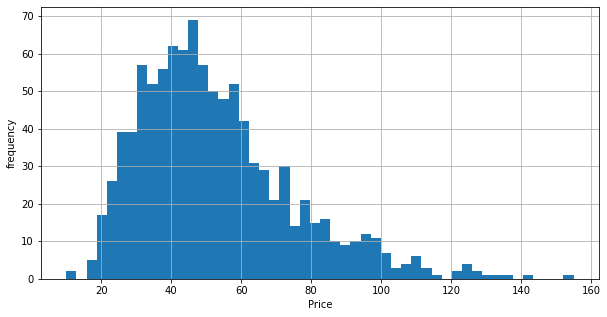

In [4]:
plt.figure(figsize= (10,5))
plt.hist(S[-1], bins=50)
plt.grid(True)
plt.xlabel('Price')
plt.ylabel('frequency')

Let’s look at the histogram of all simulated end-of-period option values

Text(0, 0.5, 'frequency')

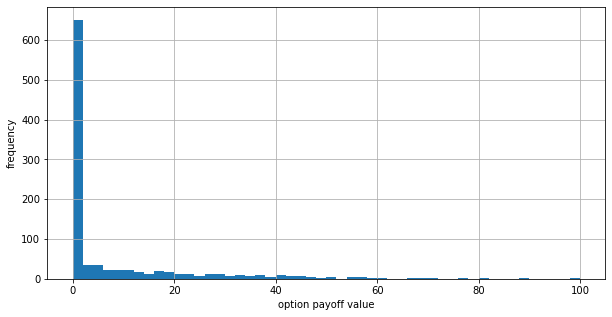

In [5]:
plt.figure(figsize= (10,5))
plt.hist(np.maximum(S[-1] - K, 0), bins=50)
plt.grid(True)
plt.xlabel('option payoff value')
plt.ylabel('frequency')

## 3. The quantum approach

Traditional Monte Carlo methods generally require extensive computational resources. By leveraging the laws of quantum mechanics, a quantum computer may provide novel ways to solve computationally intensive problems. 

Quantitative finance may benefit from quantum computing in many ways. Recently developed applications of gate-based quantum computing algorithms for use in finance include portfolio optimisation, the calculation of risk measures and pricing derivatives. Several of these applications are based on an algorithm called Amplitude Estimation, which can estimate a parameter's value with a convergence rate in the order of $\mathcal{O}(M^{-1})$, where $M$ is the number of samples required. This represents a theoretical quadratic speed-up compared to Monte Carlo methods that run on classical computers with a convergence rate of $\mathcal{O}(M^{-1/2})$. 

Below is a graphical demonstration of this speedup taken from a paper called Option Pricing Using Quantum Computers (https://arxiv.org/abs/1905.02666). The y-axis depicts the estimation error of the function or parameter we are trying to model, versus the number of samples we use, $M$, to create the estimate. 

<img src="scalingMC.png" width=600 height=600 />

### Pricing options with Quantum Amplitude Estimation

If we were to swap out the Monte Carlo estimate for the underlying share price and use Amplitude Estimation, the building blocks needed to price the option on a gate-based quantum computer are the following:

1) Represent the probability distribution $ \mathbb{P} $ describing the evolution of the share price of QuantumTech on a quantum computer.
$$ \thinspace $$
2) Construct the quantum model which computes the payoff of the option, $f(\textbf{X})$.
$$ \thinspace $$
3) Calculate the expectation value of the payoff $\mathbb{E}_\mathbb{P}[f(\textbf{X})]$.

In the paper Quantum Risk Analysis (https://arxiv.org/abs/1806.06893) you can find a detailed description of how to use Amplitude Estimation to calculate the expectation value of a function of <a href="https://www.khanacademy.org/math/statistics-probability/random-variables-stats-library/random-variables-discrete/v/random-variables">random variables</a>, how to load a relevant probability distribution to a quantum register and the construction of the quantum circuits needed to compute the payoff and set up Amplitude Estimation to estimate the expectation value of the payoff. There is also <a href="https://qiskit.org/documentation/tutorials/algorithms/07_grover.html">a chapter in the qiskit textbook</a> explaining Amplitude Estimation in more detail.

Continuing with our example of a 1-month <a href="http://www.theoptionsguide.com/call-option.aspx">European call option</a> based on the share price of QuantumTech $S_T$ and a strike price $K$, recall that the corresponding payoff function is defined as:

$$f(S_T)=\max(S_T - K, 0).$$

We now know that the price of this type of option depends only on the distribution of $S_T$. In the rest of this notebook, we will use a quantum algorithm that employs Amplitude Estimation to estimate the expected payoff, i.e., the fair price for the option:

$$\mathbb{E}\left[ \max(S_T - K, 0) \right]$$

In [6]:
#First we import all the required libraries
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation
from qiskit_finance.circuit.library import LogNormalDistribution, EuropeanCallPricingObjective

### Recapping our quantum understanding

Quantum models consist of quantum circuits that contain operations which rotate qubits in different ways. Depending on the types of rotations used, these will influence the outcome of the quantum circuit when we measure each qubit. From the preliminary notebook, we know that when a qubit is measured, it collapses to a classical outcome of either 0 or 1. But, we must also remember that the outcome of quantum measurements when qubits are in superposition is stochastic, meaning, we must measure the circuit several times to get an accurate distribution over the possible outcomes. These possible outcomes are what we call basis states, and each of them have corresponding probability amplitudes which tell us how probable the basis states are of being measured. For example, if we 2 qubits, the basis states are $00, 01, 10$ and $11$ - each of which will have a probability associated with it.


<img src="qubit.png" width=600 height=600 />

### Distribution Loading
Returning to our QuantumTech example, the first component of our option pricing model is to create a quantum circuit that takes in the probability distribution implied for the possible share prices of QuantumTech in 1 months time and loads it into a register such that each basis state represents a possible share value and its amplitude, the corresponding probability of the share having that value. 

In this notebook, we construct a circuit factory to load a log-normal probability distribution for the share price of QuantumTech into a quantum state. The share price distribution is truncated to a given interval $[low, high]$ and discretised using $2^n$ grid points, where $n$ denotes the number of qubits used. This might sound a bit confusing, so feel free to check out this blog post [INSERT LINK] for more details on loading distributions as quantum states. 

Essentially we want to represent a probability distribution of our underlying share price as a quantum state. Thus, we reduce the the distribution to an interval we deem relevant and "slice" the possible values in between this interval. The number of slices we make will depend on how many qubits we have. If we have $n$ qubits, this means we have $2^n$ equally spaced slices in the interval. Each slice corresponds to a certain share price which we can then associate with a possible basis state. Thus, the more qubits we have, the more possible basis states we will have and the more slices we can create. Let's look at an example.


### The quantum uncertainty model

In [7]:
# number of qubits to represent the uncertainty/distribution
num_uncertainty_qubits = 2

# parameters for considered random distribution
S = 50       # initial spot price
strike_price = 55
vol = 0.4     # volatility of 40%
r = 0.05      # annual interest rate of 5%
T = 30 / 365  # 30 days to maturity

# resulting parameters for log-normal distribution
mu = ((r - 0.5 * vol**2) * T + np.log(S))
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2/2)
variance = (np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
# we truncate the distribution to the interval defined by 2 standard deviations around the mean
low  = np.maximum(0, mean - 2*stddev) 
high = mean + 2*stddev

# construct circuit factory for uncertainty model
uncertainty_model = LogNormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high))

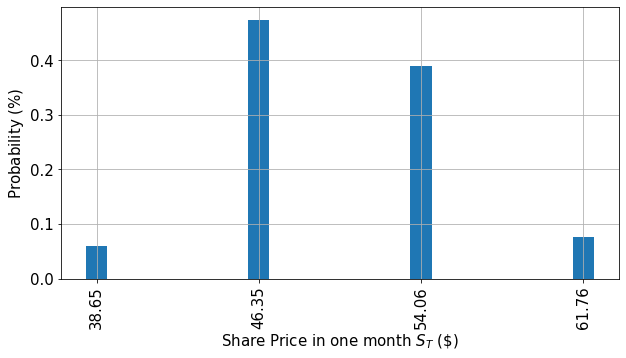

In [8]:
# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.figure(figsize= (10,5))
plt.bar(x, y, width=1)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel('Share Price in one month $S_T$ (\$)', size=15)
plt.ylabel('Probability ($\%$)', size=15)
plt.show()

### Payoff Function

Let's have a look at the payoff function for our QuantumTech option. Recall that the payoff function equals zero as long as the share price in 1 months time, $S_T$, is less than the strike price $K$ and then increases linearly thereafter. The code below illustrates this.

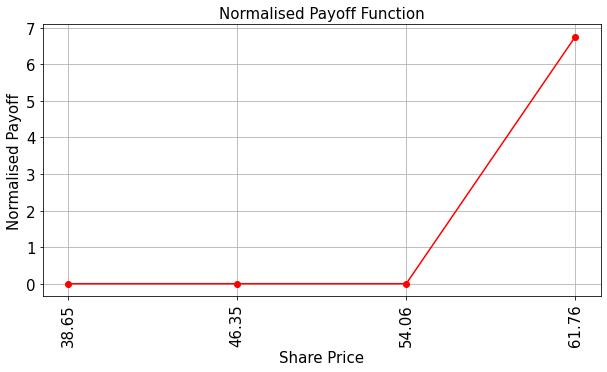

In [9]:
# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
plt.figure(figsize= (10,5))
plt.plot(x, y, 'ro-')
plt.grid()
plt.title('Normalised Payoff Function', size=15)
plt.xlabel('Share Price', size=15)
plt.ylabel('Normalised Payoff', size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

### Evaluate the expected payoff

Lastly, we can use Quantum Amplitude Estimation to compute the expected payoff of the option. Thanks to built-in Qiskit algorithms, we can use the EuropeanCallPricing and IterativeAmplitudeEstimation functions to achieve this.

In [10]:
from qiskit_finance.applications.estimation import EuropeanCallPricing

european_call_pricing = EuropeanCallPricing(num_state_qubits=num_uncertainty_qubits,
                                            strike_price=strike_price,
                                            rescaling_factor=0.25,
                                            bounds=(low, high),
                                            uncertainty_model=uncertainty_model)

In [11]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05
shots = 100
simulator = 'qasm_simulator'

qi = QuantumInstance(Aer.get_backend(simulator), shots=shots, seed_simulator=42, seed_transpiler=42)
problem = european_call_pricing.to_estimation_problem()

# construct amplitude estimation
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
result = ae.estimate(problem)

Since this example is simple enough to calculate by hand, we can compute the exact expected value of the option and compare it to the result of Amplitude Estimation using a quantum approach. 

We can also create a confidence interval around our quantum solution. Recall that we are modelling probability distributions which are inherently random. Thus, if we want, we can instead provide a range of values for our option price instead of just one fixed value. 

Below is the exact value, followed by the estimated value of the option using Amplitude Estimation. The estimation error is simply the difference between the exact and estimated values. And finally, the confidence interval provides a range of values which the model predicts the final output to lie, based on the value of alpha. 

In [12]:
# evaluate exact expected value (normalized to the [0, 1] interval)
exact_value = np.dot(uncertainty_model.probabilities, y)

conf_int = np.array(result.confidence_interval_processed)
print('Exact value:        \t%.4f' % exact_value)
print('Estimated value:    \t%.4f' % (european_call_pricing.interpret(result)))
print('Estimation error:    \t%.4f' %(np.abs(exact_value-european_call_pricing.interpret(result))))
print('Confidence interval:\t[%.4f, %.4f]' % tuple(conf_int))

Exact value:        	0.5199
Estimated value:    	0.5533
Estimation error:    	0.0334
Confidence interval:	[0.4757, 0.6309]


Ideally, we would want our model's estimated value to be as close as possible to the exact value. Thus, we would want to minimise the estimation error as much as possible. 

Now that we have implemented the quantum approach to price a call option, we can start to attempt the exercises below to enhance and create more models.

# Exercises

### Exercise 1

The estimated value for the expected payoff can be made more accurate. Can you make the estimated value closer to the exact value by tweaking various parameters? Try reducing the estimation error as much as possible and input your final values below. 

NOTE: Do not change any other variables than the ones specified below.

In [13]:
# Run this cell to get a score for your answer, copy the values for the variables here

# HINT: Try lower the estimation error to below 0.03

num_uncertainty_qubits = 2
low  = np.maximum(0, mean - 2*stddev) 
high = mean + 2*stddev
epsilon = 0.01
alpha = 0.05
shots = 100
simulator = 'qasm_simulator'

# Run this cell once you are ready to submit your answer

from grade_exercise_1 import grade_exercise_1

solutions = [num_uncertainty_qubits, low, high, epsilon, alpha, shots, simulator]

grade_exercise_1(solutions)

Your score is:  20 Good job, but try changing more parameters to get an estimation error less than 0.03!


In this exercise, your score is calculated based on the estimation error of your model. The lower the estimation error, the higher your score. The highest possible score is 100.

### Exercise 2

Recall that we can have different types of options. What we have implemented so far in this notebook is a European call option. In this exercise, try to implement a **<a href="https://www.theoptionsguide.com/put-option.aspx">European put option</a>**. A put option gives the buyer of the option the right (but not the obligation) to sell the underlying asset, rather than to buy it. Thus, a put option has a completely different payoff function to a call option. 

Let's assume the following **fixed** parameters to implement a put option:

`num_uncertainty_qubits = 4
S = 200 # initial spot price
vol = 0.3 # volatility of 30%
r = 0.08 # annual interest rate of 8%
T = 60 / 365 # 60 days to maturity
strike_price = 230
epsilon = 0.01
alpha = 0.05
shots = 100
simulator = 'qasm_simulator'`

Below is some code to get you started. 

HINT: if you are stuck, check out this qiskit tutorial and adapt it for our problem: https://qiskit.org/documentation/finance/tutorials/04_european_put_option_pricing.html.

In [14]:
# Do not change these variables

num_uncertainty_qubits = 4
S = 200 # initial spot price
vol = 0.3 # volatility of 30%
r = 0.08 # annual interest rate of 4%
T = 60 / 365 # 60 days to maturity
strike_price = 230
epsilon = 0.01
alpha = 0.05
shots = 100
simulator = 'qasm_simulator'

# set the approximation scaling for the payoff function
rescaling_factor = 0.25

# resulting parameters for log-normal distribution
mu = ((r - 0.5 * vol**2) * T + np.log(S))
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2/2)
variance = (np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2)
stddev = np.sqrt(variance)
low  = np.maximum(0, mean - 2*stddev) 
high = mean + 2*stddev
breakpoints = [low, high]
slopes = [-1, 0]
offsets = [strike_price - low, 0]
f_min = 0
f_max = strike_price - low

In [15]:
# The distribution loading step will be the same for the underlying asset, in this case the QuantumTech share 

uncertainty_model = LogNormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high))

In [16]:
from qiskit.circuit.library import  LinearAmplitudeFunction

# setup piecewise linear objective function, the LinearAmplitudeFunction


european_put_objective = LinearAmplitudeFunction(num_uncertainty_qubits, slopes,
                                                offsets, domain = (low,high),
                                                )

TypeError: __init__() missing 1 required positional argument: 'image'

In [ ]:
# setup the quantum instance to pass to the IterativeAmplitudeEstimation function

qi = QuantumInstance(Aer.get_backend(simulator), shots=shots, seed_simulator=42, seed_transpiler=42)

# construct amplitude estimation

ae = IterativeAmplitudeEstimation('insert parameters here')

In [ ]:
# Run this cell to get a score for your answer!

from grade_exercise_2 import grade_exercise_2

grade_exercise_2(uncertainty_model, european_put_objective, ae)

## Advanced reading (optional)

### Computing the delta of an option

The delta of an option measures the risk or the sensitivity of an option's change in price if the underlying asset's price changes. It is option quoted as a simple ration of the change in price of the underlying asset to the change in price of the option:

$\mathrm{delta} = \frac{\Delta S}{\Delta P}$, where $S$ is the underlying asset's price and $P$ is the price of the option. You can read more about the details of deltas for options here: https://www.investopedia.com/terms/d/delta.asp

In Qiskit, we can also conveniently compute the delta of an option. Continuing on with the parameters of our put option we just implemented, let's compute the delta.

In [ ]:
from qiskit.algorithms import EstimationProblem

In [ ]:
# setup a piecewise linear objective function
european_put_delta_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints
)

# construct circuits for payoff function
european_put_delta = european_put_delta_objective.compose(uncertainty_model, front=True)

In [ ]:
# Set up the estimation problem using qiskit 
problem = EstimationProblem(state_preparation=european_put_delta,
                            objective_qubits=[num_uncertainty_qubits])

# construct amplitude estimation
ae_delta = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)

# get the estimated result
result_delta = ae_delta.estimate(problem)

# compute the exact result
x = uncertainty_model.values
exact_delta = -sum(uncertainty_model.probabilities[x <= strike_price])


# compare results
conf_int = -np.array(result_delta.confidence_interval)[::-1]
print('Exact delta:    \t%.4f' % exact_delta)
print('Esimated value: \t%.4f' % -result_delta.estimation)
print('Estimation error:    \t%.4f' %(np.abs(exact_delta+result_delta.estimation)))
print('Confidence interval: \t[%.4f, %.4f]' % tuple(conf_int))

# Conclusion

Now that you are familiar with how quantum algorithms can be used for financial applications, go ahead and start exploring the <a href="https://qiskit.org/documentation/apidoc/qiskit_finance.html">Qiskit Finance module</a> and check out all the other types of <a href="https://qiskit.org/documentation/finance/ ">quantum finance applications</a> that are out there! You can even begin to modify the code and tailor them for problems in real life. 

### Good luck! 

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright